# Kwantyzacja kolorów


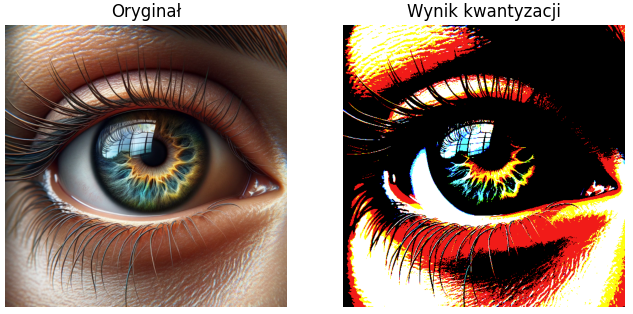

## Wstęp
Standardowy kolorowy obraz rozmiarów $n \times m$ jest reprezentowany przez $n \cdot m \cdot 3$ liczb całkowitych z przedziału $[0, 255]$. Daje to łącznie ponad 16 milionów możliwych kolorów. Kwantyzacja kolorów polega na drastycznym zredukowaniu liczby używanych kolorów w celu redukcji rozmiaru pliku, przy jednoczesnym jak najlepszym zachowaniu jakości obrazu.

## Zadanie
Zaproponuj nowy algorytm kwantyzacji kolorów z uwzględnieniem kosztów ich użycia. 

Naszym kryterium będzie ważona suma poszczególnych składników:
1. `MSE`: błąd średniokwadratowy ([mean squared error - MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) pomiędzy oryginalnym a zrekonstruowanym obrazkiem. Do jego obliczenia służy funkcja `mse`.
2. `mean_color_cost`: Średni koszt użycia kolorów. Definiujemy go jako odległość euklidesową od najbliższego "prostego" koloru w przestrzeni RGB, gdzie prostymi kolorami nazywamy: czarny (0,0,0), biały (255,255,255), czerwony (255,0,0), zielony (0,255,0), niebieski (0,0,255), żółty (255,255,0), magenta (255,0,255) oraz cyjan (0,255,255). Szczegóły znajdziesz w funkcji `color_cost`.
3. `colors_num`: Liczba użytych kolorów; także liczona w funkcji `color_cost`.

W końcu, kryterium jakości kwantyzacji to: $$MSE / 24 + mean\_color\_cost + colors\_num / 24$$

Powyższe kryterium i wszystkie funkcje, o których powyżej jest mowa, są zaimplementowane poniżej przez nas. Jednocześnie podany jest przykład trywialnej kwantyzacji, w której każdy kolor zostaje zaokrąglony do jednego z prostych (patrz wyżej) kolorów. W ten sposób koszt użycia kolorów jest równy 0, ich liczba wynosi co najwyżej 8, ale za to błąd rekonstrukcji (MSE) jest bardzo duży.

Będziesz pracować na obrazach wygenerowanych przez DALL-E oraz Stable Diffusion.

## Ograniczenia
- W tym zadaniu możesz korzystać z GPU.
- Twoja funkcja powinna zwracać skwantyzowany obraz w maksymalnie 2 minuty używając Google Colab z GPU.
- Zarówno oryginalny i skwantyzowany obrazek powinny być podane do funkcji ewaluacyjnej jako `np.array` typu `np.uint8` z wartościami z przedziału $[0, 255]$.

## Uwagi i wskazówki
- Każdy obrazek to indywidualny zbiór treningowy; podczas ewaluacji nie będą wczytywane żadne wagi wytrenowanych przez Ciebie modeli.
- Pamiętaj, że liczba użytych kolorów to Twoja decyzja.
- Jednym z podstawowych algorytmów dla kwantyzacji jest algorytm k-means, o którym dowiesz się więcej tutaj [link do wykładu]. Pamiętaj jednak, że algorytm k-means jest bardzo dobrym rozwiązaniem, gdy funkcja ewaluacji jest inna niż w tym zadaniu.

## Pliki zgłoszeniowe
Tylko ten notebook.

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`. Za pomocą skryptu `evaluation_script.py` będziesz mógł upewnić się, że Twoje rozwiązanie zostanie prawidłowo wykonane na naszych serwerach oceniających. 




# Kod startowy

In [42]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################
FINAL_EVALUATION_MODE = False
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [43]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import os
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import typing

import glob

## Ładowanie danych

In [44]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Klasa, która ułatwia wczytywanie obrazków z danego folderu
class ImageDataset:
    def __init__(self, image_dir: str):
        self.filelist = glob.glob(image_dir + "/*.jpg")
        self.IMAGE_DIMS = (512, 512)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx) -> np.ndarray:
        with Image.open(self.filelist[idx]) as image:
            image = image.convert('RGB')
            image = image.resize(self.IMAGE_DIMS)
            return np.array(image)

    def __iter__(self) -> typing.Iterator[np.ndarray]:
        return (self[i] for i in range(len(self.filelist)))

## Kod z kryterium oceniającym

In [45]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Poniżej znajdziesz definicje MSE oraz kosztu użycia kolorów
# Pamiętaj, żeby przy ewaluacji liczyć je w przestrzeni RGB, tzn. na wartościach całkowitych z przdziału [0, 255]
# Skalowanie jest dopuszczalne tylko podczas treningu!

# Zdefiniujmy kryterium oceny jakości kwantyzacji
# Użyjemy do tego błędu średniokwadratowego (mean square error - MSE)
def mse(img, img_quant):
  return ((img_quant.astype(np.float32) - img.astype(np.float32))**2).mean()


# Następnie zdefinujmy koszt użycia kolorów
# Im bliżej danemu kolorowi do "prostych" kolorów, tym mniejszy koszt jego użycia
def color_cost(img_quant):
    vertices = np.array([
        [0, 0, 0], [0, 0, 255], [0, 255, 0], [0, 255, 255],
        [255, 0, 0], [255, 0, 255], [255, 255, 0], [255, 255, 255]
    ])
    colors = np.unique(img_quant.reshape(-1,3), axis=0)
    
    differences = colors[:, np.newaxis, :] - vertices[np.newaxis, :, :]
    squared_distances = np.sum(differences**2, axis=2)
    costs = np.sqrt(np.min(squared_distances, axis=1))

    return np.mean(costs), colors.shape[0]


# Całkowite kryterium zdefiniowane w treści zadania
def quantization_score(img, img_quant):
    assert img.dtype == np.uint8
    assert img_quant.dtype == np.uint8
    
    mse_cost = mse(img, img_quant)
    color_cost_val, colors_num = color_cost(img_quant)
    print(f'MSE: {mse_cost:.4f}, color cost: {color_cost_val:.4f}, colors: {colors_num:.4f}')
    return mse_cost / 24 + color_cost_val + colors_num / 24

## Przykładowe rozwiązanie
Poniżej prezentujemy proste rozwiązanie, które w oczywisty sposób nie jest optymalne. Służy temu, aby było wiadomo w jaki sposób ma działać cały notatnik.

In [46]:
if not FINAL_EVALUATION_MODE:
    # Kwantyzuje obraz poprzez zaokrąglenie wszystkich wartości do 0 lub 255
    def starter_quantization_algorithm(img):
        threshold = 128
        quantized_array = np.where(img < threshold, 0, 255)
        return quantized_array.astype(np.uint8)


In [47]:
# Wyświetl zestawienie oryginału i zkwantyzowanego obrazka
def show_quantization_results(original, quantized):
        _, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(original)
        ax[0].set_title("Oryginał")
        ax[0].axis("off")

        ax[1].imshow(quantized)
        ax[1].set_title("Wynik kwantyzacji")
        ax[1].axis("off")
        plt.show()

MSE: 7100.0288, color cost: 0.0000, colors: 8.0000
Wynik całkowity: 296.1679


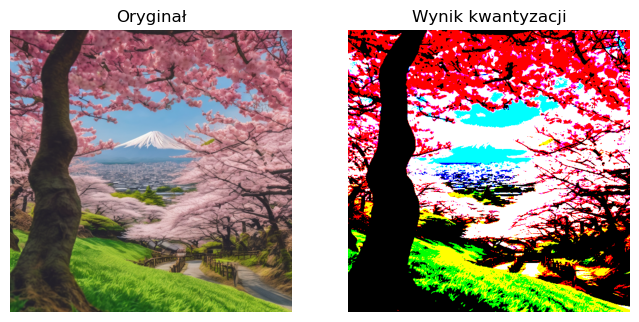

MSE: 4966.0576, color cost: 0.0000, colors: 8.0000
Wynik całkowity: 207.2524


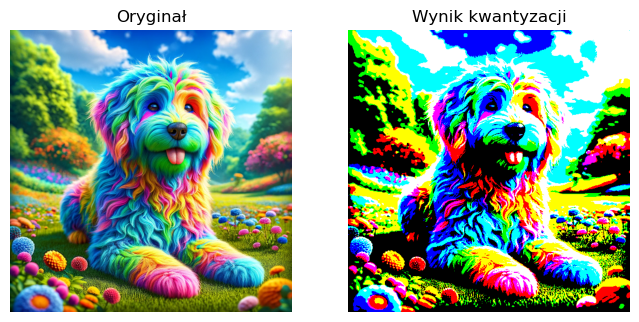

In [48]:
if not FINAL_EVALUATION_MODE:
    for image in ImageDataset('valid_data'):
        # Skwantyzujmy zdjęcie
        quantized_image = starter_quantization_algorithm(image)
        # Policzmy wynik dla otrzymanej kwantyzacji
        score = quantization_score(image, quantized_image)
        print(f'Wynik całkowity: {score:.4f}')
        # Zobaczmy jak wygląda skwantywzowane zdjęcie
        show_quantization_results(image, quantized_image)

# Twoje rozwiązanie

Ta sekcja to miejsce na Twoje rozwiązanie. Tylko tutaj powinieneś wprowadzać zmiany!

In [49]:
import numpy as np
from sklearn.mixture import GaussianMixture

import numpy as np

class CustomGMM(GaussianMixture):
    def __init__(self, n_components=1, covariance_type='full', tol=1e-3, reg_covar=1e-6, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10):
        super().__init__(n_components=n_components, covariance_type=covariance_type, tol=tol, reg_covar=reg_covar, max_iter=max_iter, n_init=n_init, init_params=init_params, weights_init=weights_init, means_init=means_init, precisions_init=precisions_init, random_state=random_state, warm_start=warm_start, verbose=verbose, verbose_interval=verbose_interval)

    def custom_predict(self, X):
        # Proste kolory w przestrzeni RGB
        simple_colors = np.array([[0, 0, 0],  # czarny
                                  [255, 255, 255],  # biały
                                  [255, 0, 0],  # czerwony
                                  [0, 255, 0],  # zielony
                                  [0, 0, 255],  # niebieski
                                  [255, 255, 0],  # żółty
                                  [255, 0, 255],  # magenta
                                  [0, 255, 255]])  # cyjan

        # Obliczamy odległość euklidesową od każdego punktu do każdego "prostego" koloru
        distances = np.sqrt(((X[:, np.newaxis] - simple_colors) ** 2).sum(axis=2))
        
        # Przypisujemy etykiety klastrów na podstawie minimalnej odległości
        labels = np.argmin(distances, axis=1)
        
        return labels


def your_quantization_algorithm(img):
    # Przekształcamy obraz do jednowymiarowej tablicy pikseli
    h, w, d = img.shape
    reshaped_img = img.reshape(h * w, d)

    # Tworzymy model GMM
    num_clusters = 16  # Zwiększamy liczbę klastrów
    gmm = CustomGMM(n_components=num_clusters, covariance_type='full', random_state=0, max_iter=500)

    # Dopasowujemy model do danych pikseli
    gmm.fit(reshaped_img)

    # Przypisujemy każdy piksel do najbliższego klastra za pomocą niestandardowej metody predict
    labels = gmm.custom_predict(reshaped_img)

    # Znajdujemy centra klastrów
    cluster_centers = gmm.means_

    # Tworzymy zredukowany obrazek z użyciem przypisanych kolorów
    quantized_img = cluster_centers[labels].reshape((h, w, d)).astype(np.uint8)

    return quantized_img


# Ewaluacja

Poniższy kod będzie służył ewaluacji rozwiązania. Po wysłaniu rozwiązania do nas zostanie wykonana funkcja `evaluate_algorithm(your_quantization_algorithm, 'test_data')`, t.j. prawie identyczny kod jak niżej będzie się uruchamiał na katalogu zdjęć `test_data` dostępnym tylko dla sprawdzających zadania.

Upewnij się przed wysłaniem, że cały notebook wykonuje się od początku do końca bez błędów i bez ingerencji użytkownika po wykonaniu polecenia `Run All`.

In [50]:
def evaluate_algorithm(quantization_algorithm, data_dir):
    dataset = ImageDataset(data_dir)
    scores = []
    for image in dataset:
        quantized_image = quantization_algorithm(image)
        show_quantization_results(image, quantized_image)
        score = quantization_score(image, quantized_image)
        scores.append(score)
    return np.mean(scores)

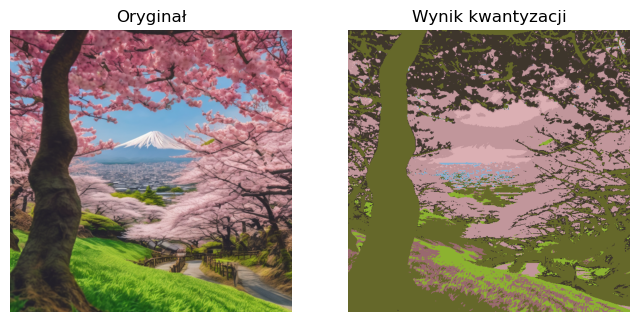

MSE: 2290.2512, color cost: 141.5394, colors: 8.0000


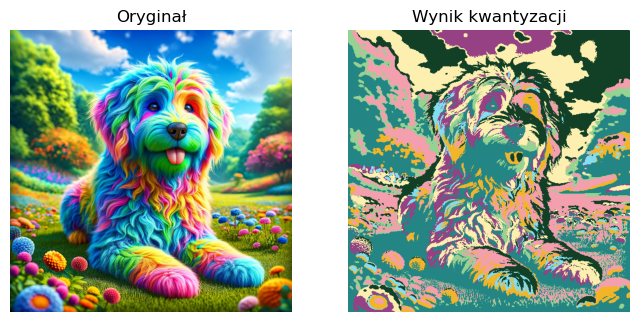

MSE: 11681.3115, color cost: 125.8478, colors: 8.0000
425.1011325677373


In [51]:
if not FINAL_EVALUATION_MODE:
    print(evaluate_algorithm(your_quantization_algorithm, 'valid_data'))
